# Classification
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

# Dataset 

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


# Exploratory Data Analysis 

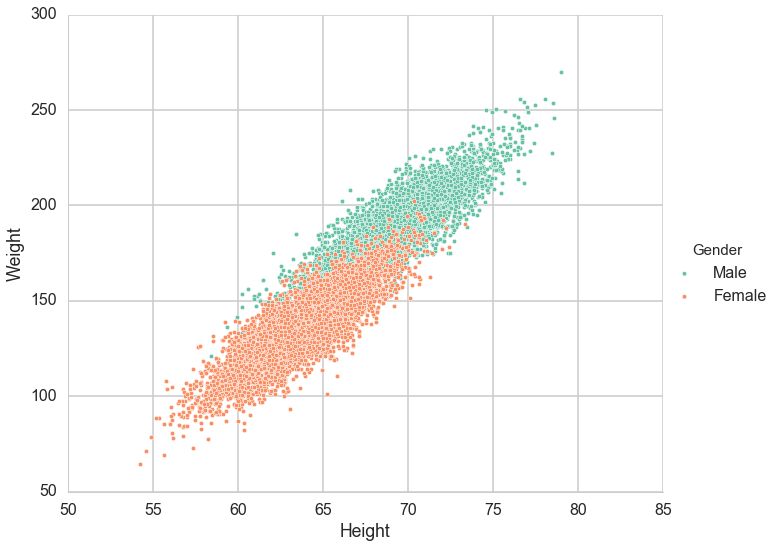

In [3]:
import seaborn as sns 

sns.pairplot(data=dflog, kind="scatter", x_vars=["Height"],y_vars=["Weight"],hue="Gender", palette="Set2",size=8,aspect=1.2)
plt.show()


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


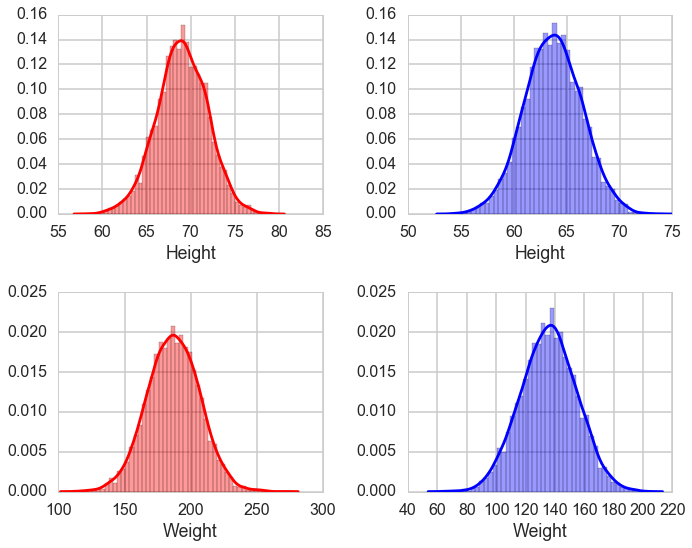

In [4]:
f, axes = plt.subplots(2,2, figsize=(10, 8))

c = ["Height","Weight"]
m = dflog[dflog.Gender=="Male"]
f = dflog[dflog.Gender!="Male"]
for i, var in enumerate(c):
    sns.distplot( m[var] ,color='red', ax=axes[i,0],label="Male")
    sns.distplot( f[var],color='blue', ax=axes[i,1],label="Female")
plt.tight_layout()

# Train Test Split 

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)



# Logistic Regression 

In [6]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


# Model Tuning  
* Tuning the Regularization parameter C
* Kfold cross validation 

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [8]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(" CV Score of basic logistic regression " + str(score))

 CV Score of basic logistic regression 0.917066666667


In [9]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
tscore=[]
for c in Cs:
    clf = LogisticRegression(C=c)
    score = cv_score(clf, Xlr, ylr)
    tscore.append(cv_score(clf,Xtestlr, ytestlr))
    print('CV Score of logistic regression with C = ' + str(c) + ' score : ' + str(score))


CV Score of logistic regression with C = 0.001 score : 0.916933333333
CV Score of logistic regression with C = 0.1 score : 0.917066666667
CV Score of logistic regression with C = 1 score : 0.917066666667
CV Score of logistic regression with C = 10 score : 0.917066666667
CV Score of logistic regression with C = 100 score : 0.917066666667


We have 4 options C [0.1, 1, 10, 100] which give high CV score

In [10]:
print("CV Score for the test data is ",tscore)

CV Score for the test data is  [0.92280000000000018, 0.9224, 0.9224, 0.9224, 0.9224]


When we look at the CV score of test data , we find the results different. C =0.1 gives a better score !

# Model Tuning with GridSearch   
* Tuning the Regularization parameter C and finding the optimum value 


In [11]:
from sklearn.model_selection import GridSearchCV
#the grid of parameters to search over

Cs = [0.001, 0.1, 1, 10, 100]
params = {'C': Cs }

          
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, params, cv=5)

# Fit it to the data
logreg_cv.fit(Xlr,ylr)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 0.001}
Best score is 0.9172


In [12]:
yp = logreg_cv.predict(Xtestlr)

print(accuracy_score(yp, ytestlr))

0.9256


* We see that the new C=0.001 gives a better score for both the training data and the testdata 

# Using SVM for classification

In [13]:


from sklearn.model_selection import GridSearchCV 
from sklearn import svm

svr = svm.SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 10]}

svcm = GridSearchCV(svr, parameters)
svcm.fit(Xlr, ylr)
print("Score of training set {}".format(svcm.best_score_))


print("Score of test set "+str(accuracy_score(svcm.predict(Xtestlr), ytestlr)))
#print(wvcm.get_params())



Score of training set 0.9168
Score of test set 0.926
